### 线性回归
算法推导过程中已经给出了求解方法，基于最小二乘法直接求解，但这并不是机器学习的思想，由此引入了梯度下降方法。该实验重点理解梯度下降每一步流程与实验对比分析

#### 主要内容
- 线性回归方程实现
- 梯度下降效果
- 对比不同梯度下降策略
- 建模曲线分析
- 过拟合与欠拟合
- 正则化作用
- 提前停止策略

In [3]:
%matplotlib inline

import os
import warnings

from matplotlib import pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#### 回归方程：
[!回归方程](../images/linear.png)

In [2]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

(0.0, 2.0, 0.0, 15.0)

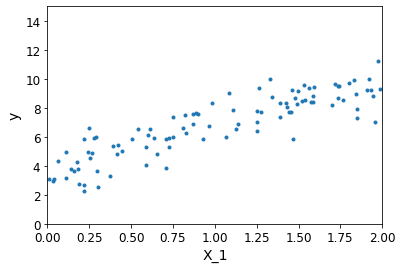

In [9]:
plt.plot(X, y, '.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.axis([0,2, 0, 15])

#### 参数直接求解法

In [10]:
X_b = np.c_[np.ones((100, 1)), X]
# np.linalg.inv求逆
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [15]:
X_new = np.array([[0], [2]])
X_new_ = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_.dot(theta_best)

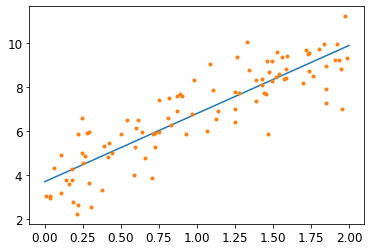

In [18]:
plt.plot(X_new, y_predict, '-')
plt.plot(X, y, '.')

#### sklearn API文档：
https://scikit-learn.org/stable/modules/classes.html



#### 工具包实现

In [20]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)
print(reg.coef_)
print(reg.intercept_)

[[3.09151849]]
[3.70209481]


### 梯度下降
[!梯度下降原理](../images/gradient.png)

In [21]:
theta_best

array([[3.70209481],
       [3.09151849]])